# Sentiment Analysis over Yelp reviews

This notebook shows how to build a text classifier that can predict whether a review is negative or positive. We used Yelp dataset, made public thanks to the Yelp-challenge. I am only doing this for fun and practice, please don't hesitate to correct me if you see any mistake or if you have any question. The notebook will be improved overtime when I implement newer algorithms and corrections. 

The Yelp reviews consist in a list of json documents that contain the following information:
    
- business_id
- date
- review_id
- stars
- text
- type
- user_id
- votes
    
For classifying our reviews, we are going to use a Naive Bayes approach at fist, then use fancier model and see how it improves. Classification problem is a supervised learning task, which means we deal with labelled data. Here, every review has a rating, which consist of stars from 1 to 5. For our classifier, we are going to use two classes: `pos` and `neg` for positive versus negative reviews. As an arbitrary choice, we will say that a positve review is rated above 3 stars. 

I am programming in Python, along with libraries like `scikit-learn` or `gensim`. 

In [1]:
import numpy as np
import json

### Building a Corpus Class

To have an easier access to our data, we are going to build a Class called `JsonCorpus` and its parent Class called `Corpus`. 

`Corpus` will have two basics methods:

- `__init__(self, path)` for registering dataset path as an attribute
- `__iter__(self)` so we can read the full dataset review by review. Since the dataset is pretty big, the whole thing won't fit in RAM. Thanks to this approach, we can train our model on the whole corpus one review at a time. 

`JsonCorpus` will add a few methods to our `Corpus` class:

- `__parse_json(self, line)` which is private method, that parse a json string representation to a json object
- `__stars_to_sentiment(self, stars, pos_threshold)` is a private method that converts stars rating to `pos` or `neg` depending on `pos_threshold`.
- `head(self, n, return_type)` that returns the first `n` reviews in a specified format

In [2]:
class Corpus(object):
    def __init__(self, path):
        self.path = path
        
        
    def __iter__(self):
        for line in open(self.path):
            yield line


class JsonCorpus(Corpus):
    def __init__(self, path):
        super(JsonCorpus, self).__init__(path)
            
            
    def __parse_json(self, line):
        return json.loads(line)
    
    
    def __stars_to_sentiment(self, star, pos_threshold=3):
        return 'pos' if star > pos_threshold else 'neg'
            
        
    def head(self, n=1, return_type='json'):
        with open(self.path) as file:
            json = [self.__parse_json(next(file).strip()) for x in xrange(n)]
            
            if return_type is 'json':
                # returns a list of plain json documents
                return json
            elif return_type is 'text_rating':
                # returns a list of [text, stars] documents
                return [[j['text'], j['stars']] for j in json]
            elif return_type is 'text_sentiment':
                # returns a list of [text, sentiment] documents
                return [[j['text'], self.__stars_to_sentiment(j['stars'])] for j in json]
            else:
                raise NameError('invalid return_type')

In [3]:
corpus = JsonCorpus('../dataset/yelp_academic_dataset_review.json')

In [4]:
corpus.head()

[{u'business_id': u'5UmKMjUEUNdYWqANhGckJw',
  u'date': u'2012-08-01',
  u'review_id': u'Ya85v4eqdd6k9Od8HbQjyA',
  u'stars': 4,
  u'text': u'Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.',
  u'type': u'review',
  u'user_id': u'PUFPaY9KxDAcGqfsorJp3Q',
  u'votes': {u'cool': 0, u'funny': 0, u'useful': 0}}]

In [5]:
corpus.head(1, 'text_sentiment')

[[u'Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.',
  'pos']]

## Naive Bayes classifier

Now that our corpus is ready, let's dive into Natural Language Processing! We are first going to use `scikit-learn` library, as it provides a lot of algorithms, and is pretty easy to use.

### Introduction to classification, a playground example

With this playground example, we are goin to build a classifier prototype to understand how `scikit-learn` works, and what classification is about.

The first idea is to convert raw words into vectors, so that the algorithm can understand them and classify sentences. We use what is called a bag of words approach: we gather all the words occuring in our corpus as a vocabulary base, giving us a `N` dimensional space, where `N` is how many unique words we have in the vocabulary. We can then map our sentences as vectors in our `N` dimensional space according to the words they contains. Things get clearer with a simple example:

Let's say our corpus consists of two sentences "I feel good" and "I feel bad". Our vocabulary is `["I", "feel", "good", "bad"]`. This is a 4 dimensional space in which our two sentences can be expressed as vectors of components `[1, 1, 1, 0]` and `[1, 1, 0, 1]`. Basically, we can say we have "vectorized" our textual data by expressing our sentences as vectors in a high dimensional space. High dimensional because vocabulary size gets very big, hence the size of our vector space. Our two vectors form a term-document matrix, because every document (review) is mapped to terms in our vocabulary.

Then, our algorithm is going to learn how to classify based on the training data we feed it. Recall that our training data consists of the text and the corresponding label. We use a Naive Bayes classifier because it is the simplest classifier to begin with. It works in the following fashion: let's say we feed our algorithm `["I hate junk food", "neg"]` it will assign probabilities for words "I", "hate", "junk", "food" to express a negative feeling. Once the training is complete, the algorithm will be able to generalize to reviews it hasn't seen yet by looking at the words in each review, and compute the probability for the sentence to be positive or negative.

We start easy by only loading 100 reviews and the corresponding labels.

In [6]:
reviews = [c[0] for c in corpus.head(100, 'text_sentiment')]
labels = [c[1] for c in corpus.head(100, 'text_sentiment')]

We then initialize a `CountVectorizer` to build the term-document matrix `X_train_counts`. You see that it has one row per review, and one column per vocabulary word, as we explained earlier. So here, there are 2176 unique words within our 100 first reviews. 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(reviews)

print "term-document matrix shape is:", X_train_counts.shape

term-document matrix shape is: (100, 2176)


Now we initialize our classifier, then train it with term-document matrix and target labels.

In [8]:
from sklearn.naive_bayes import MultinomialNB

multinomial_naive_bayes = MultinomialNB()
%time clf = multinomial_naive_bayes.fit(X_train_counts, labels)

CPU times: user 2.58 ms, sys: 1.37 ms, total: 3.95 ms
Wall time: 3.15 ms


Good, now let's try it by making up reviews and see if it can guess the sentiment:

In [9]:
print '"this is good food" classified as:',\
    clf.predict(count_vectorizer.transform(['this is good food']))
print '"that place was bad" classified as:',\
    clf.predict(count_vectorizer.transform(['that place was bad']))

"this is good food" classified as: ['pos']
"that place was bad" classified as: ['neg']


Hoorray it worked ! But wait, this is actually just the beginning, we have no idea whether our model really works, or if we just got lucky with two fairly easy examples. Read the following to discover how we can improve this classifier !

### Evaluating the model

As a first try, let's keep the same model we used, and train it on more data. Also, we will evaluate more precisely how our model performed, and to do so we are going to split the dataset in training and test data. Usually, we use 80% and 20% size for training and test respectively. Our goal is to see how well the model we trained is capable of generalizing on reviews it hasn't seen in training data.

Let's load 20000 reviews and their labels, then split this dataset in training and test sets thanks to `scikit-learn` `train_test_split` function.

In [20]:
from sklearn.model_selection import train_test_split

X, y = [c[0] for c in corpus.head(500000, 'text_sentiment')],\
        [c[1] for c in corpus.head(500000, 'text_sentiment')]
    
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

Now we will train the model. We now use a `Pipeline`, which is a Class allowing to easily chain steps, like our vectorizer followed by the classifier. Once trained, `metrics` module displays some useful training results.

In [11]:
from sklearn import metrics
from sklearn.pipeline import Pipeline

text_clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

%time text_clf_1.fit(X_train, y_train)

print metrics.classification_report(y_test, text_clf_1.predict(X_test))

CPU times: user 21.4 s, sys: 674 ms, total: 22.1 s
Wall time: 22.2 s
             precision    recall  f1-score   support

        neg       0.81      0.74      0.77     14523
        pos       0.86      0.90      0.88     25477

avg / total       0.84      0.84      0.84     40000



0.82 precision score, which means about 80% of our reviews have been correctly classified. Is it good ? Not really... we sure can do better !

### Stochastic Gradient Descent (SGD) classifier

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

text_clf_2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', 
                          penalty='l2', 
                          alpha=1e-3, 
                          n_iter=5, 
                          random_state=42)),
    ])

%time text_clf_2.fit(X_train, y_train)
print '\ntext_clf_2\n %s \n' %metrics.classification_report(y_test, 
                                                            text_clf_2.predict(X_test))

CPU times: user 1min 3s, sys: 4.2 s, total: 1min 7s
Wall time: 1min 8s

text_clf_2
              precision    recall  f1-score   support

        neg       0.90      0.58      0.71     36730
        pos       0.80      0.96      0.87     63270

avg / total       0.84      0.82      0.81    100000
 



In [13]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [14]:
print text_clf_2.predict(['oh I love this place it is so good the food is nice'])
print text_clf_2.predict(['the food was really bad'])

['pos']
['neg']


In [15]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), ((1, 3))],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3) 
}

In [16]:
gs_clf = GridSearchCV(text_clf_2, parameters, n_jobs=-1)

In [17]:
# %time gs_clf.fit(X_train, y_train)

In [18]:
# pd.DataFrame(gs_clf.cv_results_ ).sort_values(by='mean_test_score', ascending=False)

In [22]:
from sklearn.externals import joblib
joblib.dump(text_clf_2, '../applications/sentiment-classifier/application/models/sgd_clf.pkl')

['../applications/sentiment-classifier/application/models/sgd_clf.pkl']

### Word2Vec classifier

In [111]:
from gensim import models as m
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [112]:
%time sentences = [t[0].split(' ') for t in corpus.head(n=1000, return_type='text_sentiment')]

CPU times: user 51.7 ms, sys: 2.98 ms, total: 54.6 ms
Wall time: 53.4 ms


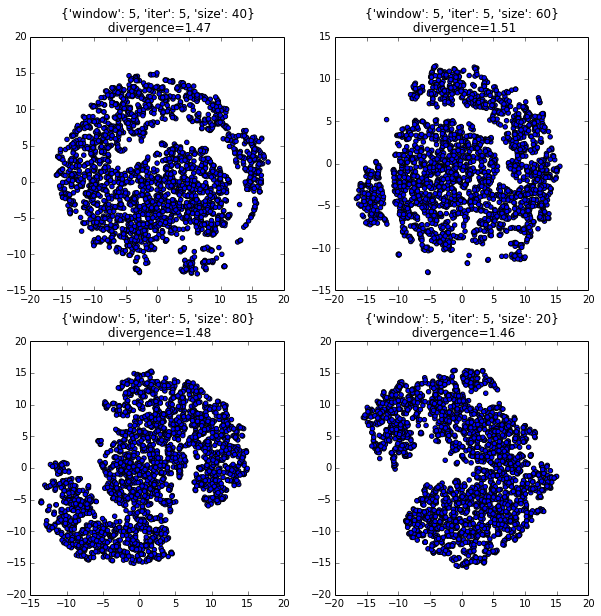

In [144]:
fig = plt.figure(figsize=(10,10))

params = [
    {'size':20, 'window': 5, 'iter': 5},
    {'size':40, 'window': 5, 'iter': 5},
    {'size':60, 'window': 5, 'iter': 5},
    {'size':80, 'window': 5, 'iter': 5},
]

for i,p in enumerate(params):
    wv_model = m.Word2Vec(sentences, size=p['size'], window=p['window'], 
                       min_count=5, workers=4, hs=1, iter=p['iter'])
    M = [model.wv[w] for w in model.wv.index2word]
    tsne_model = TSNE()
    M_2d = tsne_model.fit_transform(M)
    
    ax = fig.add_subplot(2,2,i)
    ax.scatter(M_2d[:,0], M_2d[:,1])
    plt.title('{0}\n divergence={1:0.2f}'.format(str(p), tsne_model.kl_divergence_))

fig.show()

In [174]:
wv_model.scan_vocab([['this', 'I', 'liererke']])

None
